# **CNN - MNIST Project**
---
---

## **Perform Standard Imports**

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **Load MNIST DataSet**

In [32]:
transform = transforms.ToTensor()

In [33]:
train_data = datasets.MNIST(root ='../Data', train= True, transform = transform, download = True)

In [34]:
test_data = datasets.MNIST(root ='../Data', train= False, transform = transform, download = True)

In [35]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [36]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

## **Create Loaders**

In [37]:
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = True)

# **CODE FOR DEMOSTRATION PURPOSE**
---
---

## **Define Convolutional Layers**

In [38]:
# 1st Convolutional Layer

conv1 = nn.Conv2d(in_channels = 1,
                  out_channels = 6,                   #Filter = 6
                  kernel_size = 3,
                  stride = 1)

In [39]:
# 2nd Convolutional Layer

conv2 = nn.Conv2d(in_channels = 6,
                  out_channels = 16,                    #Filter = 16
                  kernel_size = 3,
                  stride = 1)

In [40]:
# Grab the first MNIST record
for i,(X_train, y_train) in enumerate(train_data):
  break

# Shape of 1 Image - 3 dimension

X_train.shape

torch.Size([1, 28, 28])

In [41]:
# As we are sending the images in batch - Make it in 4 Dimension - Batch of 1 image
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)


x = X_train.view(1,1,28,28)
x.shape

torch.Size([1, 1, 28, 28])

In [42]:
# Passing through First Convolution Layer

x = F.relu(conv1(x))
x.shape

torch.Size([1, 6, 26, 26])

In [43]:
# Border information is getting loose --> 28*28 became 26*26

# include Pooling

x = F.max_pool2d(input = x, kernel_size = 2, stride = 2)
x.shape

torch.Size([1, 6, 13, 13])

In [44]:
## after maxpolling dimension reduces --> 26*26 to 13*13

In [45]:
## passing the x from the 2nd Convulation layer

x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [46]:
# Run the second pooling layer

x = F.max_pool2d(input = x, kernel_size = 2, stride = 2)
x.shape

torch.Size([1, 16, 5, 5])

In [47]:
# Flatten the data
x = x.view(-1, 5*5*16)
print(x.shape)

torch.Size([1, 400])


---
---
## **Proper Code - Build Class**

In [48]:
class ConvolutionalNetwork(nn.Module):

  def __init__(self):
    super().__init__()

    # Comvolutional Layer
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3 , stride = 1)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3, stride = 1)

    # Fully Connected Layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)

    # Output Layer
    self.fc3 = nn.Linear(84, 10)


  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)
    X = X.view(-1, 16*5*5)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim = 1)

In [72]:
torch.manual_seed(42)

model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [73]:
# Check No of Elements in our model

for param in model.parameters():
  print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


### **Define Loss Function and Optimizer**

In [74]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

## **Train The Model**

In [75]:
import time

start_time = time.time()


# Variables
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop Epochs

for i in range(epochs):

  trn_corr = 0
  test_corr = 0

  # TRAIN
  # ----------------------------------------------------------------------------------------------
  # ----------------------------------------------------------------------------------------------
  for b,(X_train, y_train) in enumerate(train_loader):

    b= b+1

    # Apply the Model
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    # TRACKING number of correct predictions - NOT MANDATORY
    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    # Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print interim results
    if b%600 ==0:
      print(f"EPOCH : {i}    BATCH : {b}   LOSS : {loss.item()}")

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # TEST
  # ----------------------------------------------------------------------------------------------
  # ----------------------------------------------------------------------------------------------
  with torch.no_grad():
    for b,(X_test, y_test) in enumerate(test_loader):

      # Apply the model
      y_val = model(X_test)

      # Tally the number of correct predictions
      predicted = torch.max(y_val.data, 1)[1]
      test_corr += (predicted == y_test).sum()

  # TRACKING PURPOSE - NOT MANDATORY
  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(test_corr)




current_time = time.time()
time_took = current_time-start_time
print(f"time took : {time_took} seconds" )

EPOCH : 0    BATCH : 600   LOSS : 0.04055623337626457
EPOCH : 0    BATCH : 1200   LOSS : 0.08253474533557892
EPOCH : 0    BATCH : 1800   LOSS : 0.3642268180847168
EPOCH : 0    BATCH : 2400   LOSS : 0.018563713878393173
EPOCH : 0    BATCH : 3000   LOSS : 0.007250106427818537
EPOCH : 0    BATCH : 3600   LOSS : 0.002830152865499258
EPOCH : 0    BATCH : 4200   LOSS : 0.6060358881950378
EPOCH : 0    BATCH : 4800   LOSS : 0.02749655209481716
EPOCH : 0    BATCH : 5400   LOSS : 0.00948194321244955
EPOCH : 0    BATCH : 6000   LOSS : 0.033807139843702316
EPOCH : 1    BATCH : 600   LOSS : 0.004514424595981836
EPOCH : 1    BATCH : 1200   LOSS : 0.02518085204064846
EPOCH : 1    BATCH : 1800   LOSS : 0.0941455215215683
EPOCH : 1    BATCH : 2400   LOSS : 0.09428799897432327
EPOCH : 1    BATCH : 3000   LOSS : 0.004918348975479603
EPOCH : 1    BATCH : 3600   LOSS : 0.04892195388674736
EPOCH : 1    BATCH : 4200   LOSS : 0.008655870333313942
EPOCH : 1    BATCH : 4800   LOSS : 0.023962387815117836
EPOCH :

## **Plot the loss and accuracy comparisons**

In [80]:
# train_losses = torch.tensor(train_losses, requires_grad = True)
# test_losses = torch.tensor(test_losses, requires_grad = True)

# train_losses = [fl.detach() for fl in train_losses ]
# test_losses = [fl.detach() for fl in test_losses ]

In [77]:
train_losses

[tensor(0.0338),
 tensor(0.0037),
 tensor(0.0021),
 tensor(0.0026),
 tensor(0.0811)]

In [81]:
train_losses = torch.tensor(train_losses, requires_grad = True)

In [87]:
train_losses.detach().numpy()

array([0.03380714, 0.0036643 , 0.00209662, 0.00263513, 0.08105738],
      dtype=float32)

In [90]:
test_losses = torch.tensor(test_losses, requires_grad = True)

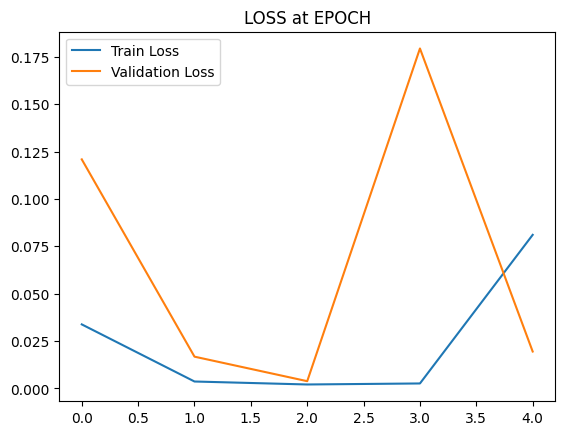

In [91]:

plt.plot(train_losses.detach().numpy(), label = 'Train Loss')
plt.plot(test_losses.detach().numpy(), label = 'Validation Loss')
plt.title("LOSS at EPOCH")
plt.legend()

In [92]:
test_correct

[tensor(9783), tensor(9833), tensor(9840), tensor(9861), tensor(9868)]

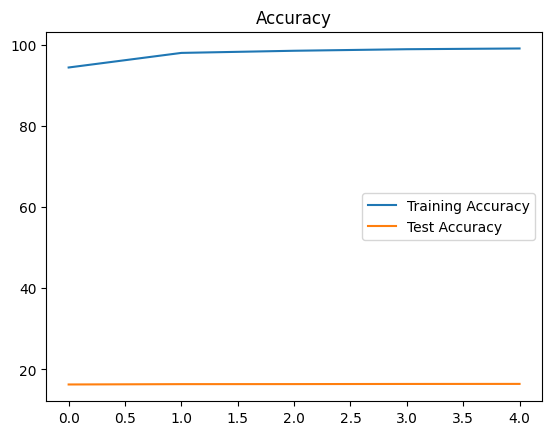

In [93]:
plt.plot([t/600 for t in train_correct], label = "Training Accuracy")
plt.plot([t/600 for t in test_correct], label = "Test Accuracy")
plt.title("Accuracy")
plt.legend()

## **Evaluate the Test Data**

In [94]:
test_load_all = DataLoader(test_data, batch_size = 10000, shuffle = False)

In [95]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_all:
    y_val = model(X_test)

    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()


In [96]:
correct.item()/len(test_data)

0.9868